# ÖNSZERV HF7

In [1]:
%pylab inline
from scipy.optimize import curve_fit # Az illesztéshez használt függvény
from numpy.fft import *              # Fourier-analízishez használt rutinok
from scipy.signal import spectrogram # Spektrogramm készítő függvény
from scipy.interpolate import interp1d # Interpoláció
import scipy.integrate as integrate # Integrálás
import sys
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import imageio

Populating the interactive namespace from numpy and matplotlib


## Feladatok:

A járványterjedés SIR modellje már korábban előkerült az előadásban. A  modell egy változata figyelembe veszi, hogy az immunitás jelen van valamilyen $\mu$ rátával. Ennek megfelelően az egyenletek így alakulnak:


$$ \frac{ds}{dt} = -\beta \cdot s \cdot i + \mu \cdot r $$

$$ \frac{di}{dt} = \beta \cdot s \cdot i - \gamma \cdot i $$

$$ \frac{dr}{dt} = \gamma \cdot i - \mu \cdot r $$

ahol $s=S/N$ a betegségre fogékonyak számának ($S$), $i=I/N$ a fertőzők számának ($I$) és $r=R/N$ a gyógyultak számának ($R$) aránya a teljes populációhoz ($N$) képest. A $\beta$ és $\gamma$ paraméterek ugyanazok, mint a SIR modellben.


1. Mutassuk meg, hogy az $s+r+i = 1$ összefüggés igaz! Disszipatív-e a rendszer? Redukáljuk háromról kettőre a változók számát az összefüggés segítségével!

2. Szimuláljuk az egyenleteket néhány realisztikus paraméter mellett! Például a gyógyulási idő $1/\gamma = 10 nap$, a $\beta/\gamma$ arány pedig éppen a reprodukciós ráta $R_0$, amire egy realisztikus szám pl. $R_0=2$. Milyen időbeli viselkedés alakul ki különböző $\mu$ paraméterek mellett?

3. Keressük meg az egyenlet fixpontjait és vizsgáljuk meg a stabilitásukat! Hogyan fognak viselkedni a fixpont közvetlen környezetéből elindított trajektóriák? Mekkora lesz az egyik fixpont körüli mozgás periódusideje a paraméterek ($\beta$, $\gamma$, $\mu$) függvényében?

## Megoldás

### 1. Feladat

A fenti egyenleteket összeadva:

$$ \frac{ds}{dt} + \frac{di}{dt} + \frac{dr}{dt} = 0 $$

Tehát

$$ s + i + r = c $$

Ahol $c$ egy konstans. Az állandóság az idő bármely pillanatában igaz! Szorozzuk be az egyenlőséget $N$-nel!

$$ S + I + R = C $$

Vizsgáljuk a kezdeti állapotot ($t=0$). Legyen $S(0)=N$ és $I(0)=0$. Ekkor látszik, hogy $R(0)=0$. Intuitívan belátható ez bármely kezdeti állapot esetén. $R(0)$ mindig $0$ lesz, mert még nem volt miből kigyógyulni, $I(0)$ lesz valamennyi, és a populáció maradék része szuszceptibilis a betegségre. Persze a betegség előbb is elkezdődhetett, mint amikor mi "elkezdtük mérni az időt", de ekkor is bármely $R(0)$-ra igaz lesz a gondolatmenet. Tehát

$$ S + I + R = N $$

Sőt, ez az idő bármely pillanatában igaz lesz. Ám kicsit szabadkezűen bántunk $C$-vel, ugyanis $N$ miért ne függhetne az időtől? Függhet, sőt, a valóságban függ is (natalitás, mortalitás, a betegség miatt elhunytak - tovább fokozva : öröklődhet bizonyos paraméterek szerint, mutálódhat $p$ eséllyel {x} paraméterben, stb. stb.)! Ettől függetlenül $S$, $R$ és $I$ összege visszaadja az aktuális populációt. Így igaz lesz az alábbi egyenlőség.

$$ s + i + r = 1 $$

Ez a kezdetektől fogva érezhető volt, mivel ez a három változó diszjunkt halmazokra osztja a populációt.

Alapvetően a tisztán SIR modelleknél a rendszer nem disszipatív, ha a teszt-populációt konstansnak vesszük. A SIRD modell veszi figyelembe azt, hogy a betegség halált okozhat.

Redukáljuk háromról kettőre a változók számát:

$$ s = 1 - i - r $$

Így az első egyenlet egy igaz állítás lesz, a másik kettő pedig

$$ \frac{di}{dt} = \beta \cdot (1 - i - r) \cdot i - \gamma \cdot i $$

$$ \frac{dr}{dt} = \gamma \cdot i - \mu \cdot r $$

### 2. Feladat

A feladatban leírtakkal ellentétben az immunitási faktort is bele szokás venni a reprodukciós rátába, de ezt hanyagoljuk. Érezhető, hogy reprodukciós ráta ténylegesen függ az immunitási faktortól, mégpedig így:

$$ R_0 = \frac{\beta}{\gamma+\mu} $$

Legyen az idő mértékegysége $[nap]$.

Az ajánlott paraméterek : $R_0 = 2$ és $1/\gamma = 10nap$

Az időbeli léptetéshez a negyedrendű Runge-Kutta módszert használom.

In [2]:
def di_func(i, r):
    return beta * (1 - i - r) * i - gamma * i

def dr_func(i, r):
    return gamma * i - mu * r


def rk(ik, rk, tv): # ezzel generáljuk ki az adatokat a kezdőfeltételekből
    if (ik+rk>1):
        print("ERRROR : S+I+R!=1")
    else:
        h = 1
        
        i = [ik] # ide jönnek a fertőzöttek
        r = [rk] # ide jönnek a gyógyultak
        
        
        for j in range(tv):
            i0 = i[-1]
            r0 = r[-1]
            
            k1i = di_func(i0, r0)
            k1r = dr_func(i0, r0)
            
            k2i = di_func(i0 + h * k1i/2, r0 + h * k1r/2)
            k2r = dr_func(i0 + h * k1i/2, r0 + h * k1r/2)
            
            k3i = di_func(i0 + h * k2i/2, r0 + h * k2r/2)
            k3r = dr_func(i0 + h * k2i/2, r0 + h * k2r/2)
            
            k4i = di_func(i0 + h * k2i, r0 + h * k3r)
            k4r = dr_func(i0 + h * k2i, r0 + h * k3r)
            
            
            i1 = i0 + (1/6)*h*( k1i + 2*k2i + 2*k3i + k4i )
            r1 = r0 + (1/6)*h*( k1r + 2*k2r + 2*k3r + k4r )
            
            i.append(i1)
            r.append(r1)
        return np.array(i),np.array(r)

In [3]:
def abra(i,r): # ezzel plotoljuk a szimulációt
    figsize(16,12)
    plt.rcParams["font.size"] = "16"
    plt.xlabel("t[nap]", fontsize = 20)
    plt.ylabel("a populáció hányad része", fontsize = 20)
    s = 1 - r - i
    t = np.linspace(0,len(i),len(i))
    plt.plot(t, i, color = "r", marker = "o", label = "Fertőzött")
    plt.plot(t, r, color = "g", marker = "o", label = "Kigyógyult")
    plt.plot(t, s, color = "b", marker = "o", label = "Szuszceptibilis")
    plt.legend(fontsize = 16)
    plt.show()

# $\mu = 0$, $\beta=0.5$, $\gamma = 0.04$

## r(0) = 0.2; i(0) = 0.1

In [4]:
mu = 0.000
gamma = 0.04
beta = 0.5

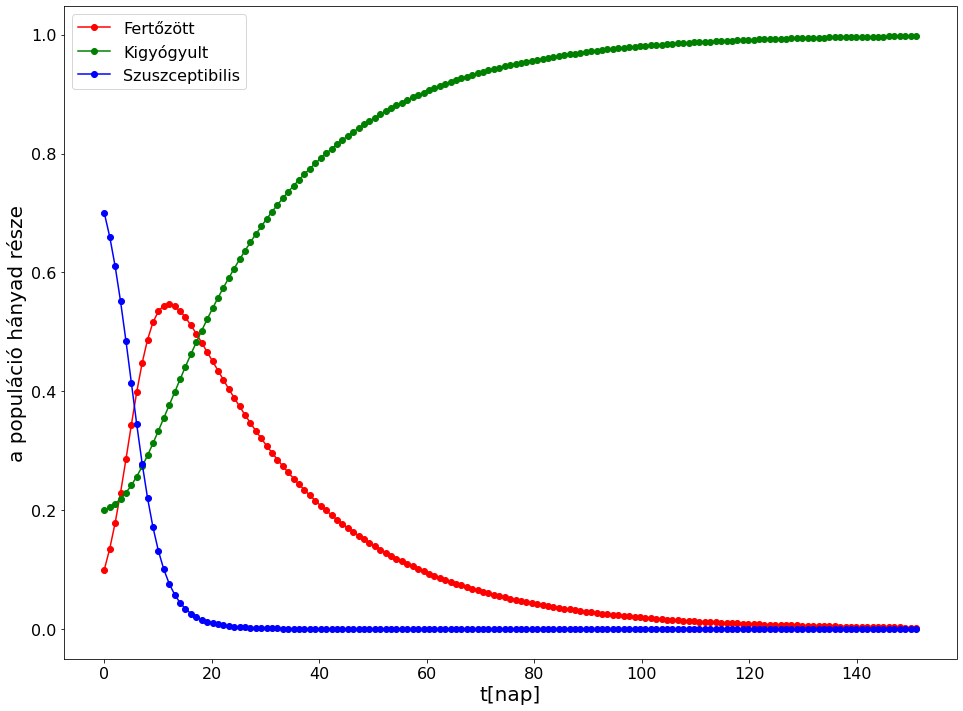

In [5]:
i, r = rk(0.1, 0.2, 150)
abra(i,r)

## r(0) = 0.0; i(0) = 0.01

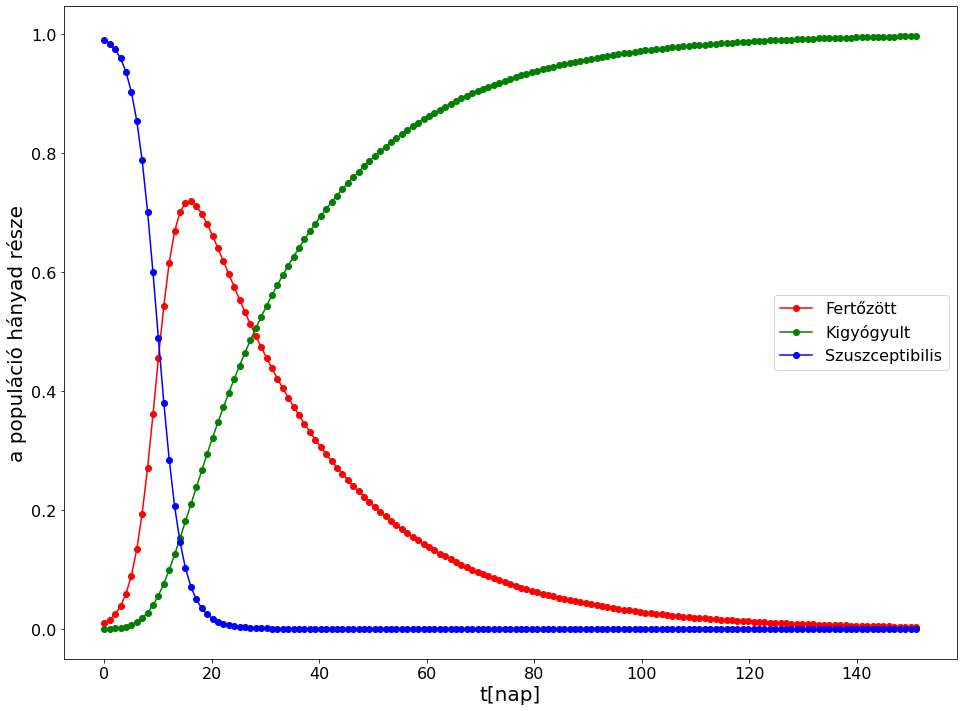

In [6]:
i, r = rk(0.01, 0, 150)
abra(i,r)

Látszik, hogy a modell működik.

# $\mu = 0$, az ajánlott paraméterekkel

In [7]:
gamma = 1/10
R0 = 2
beta = R0*gamma

In [8]:
mu = 0.000

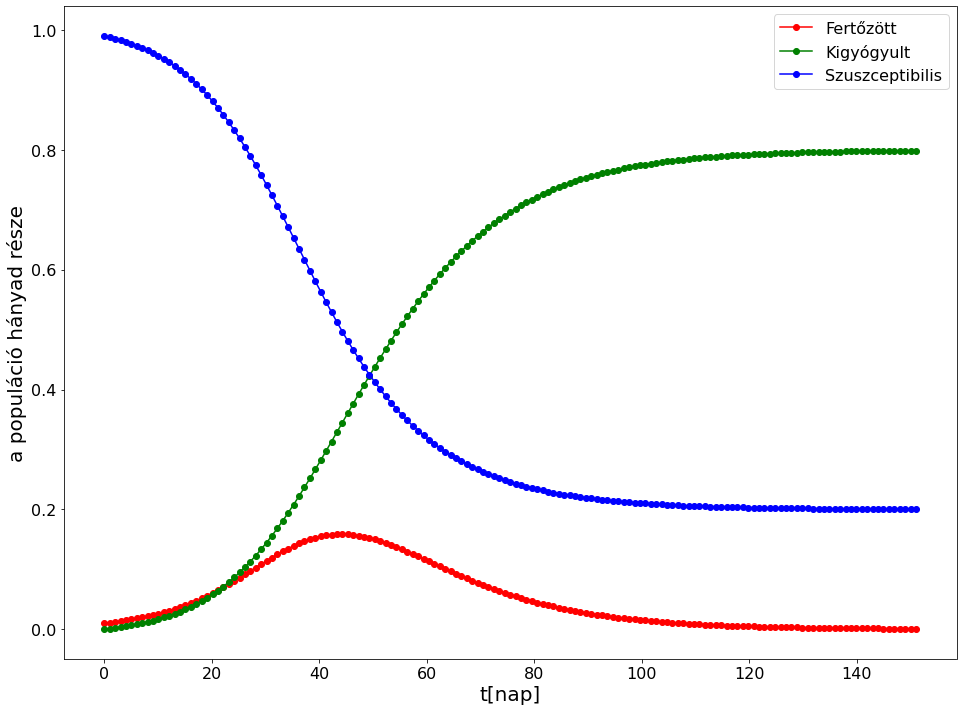

In [9]:
i, r = rk(0.01, 0, 150)
abra(i,r)

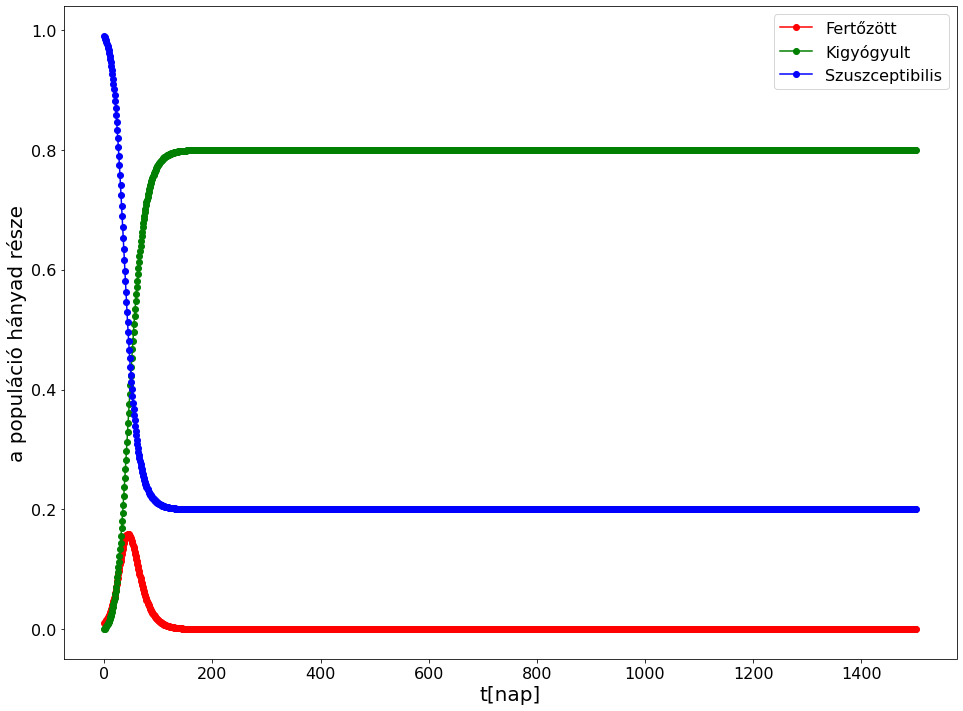

In [10]:
i, r = rk(0.01, 0, 1500)
abra(i,r)

Az előbbi paraméterekhez képest az a legljelentősebb különbség, hogy $\gamma$ sokkal nagyobb, vagyis sokkal gyorsabban átmegy a betegség az embereken. Sőt, annyiszor gyorsabban, hogy a betegség kihal, mielőbb végigmenne az egész populáción - bár még így is a populáció 80%-a érintett volt!

# $\mu \neq 0$, az ajánlott paraméterekkel

In [11]:
mu = 0.01

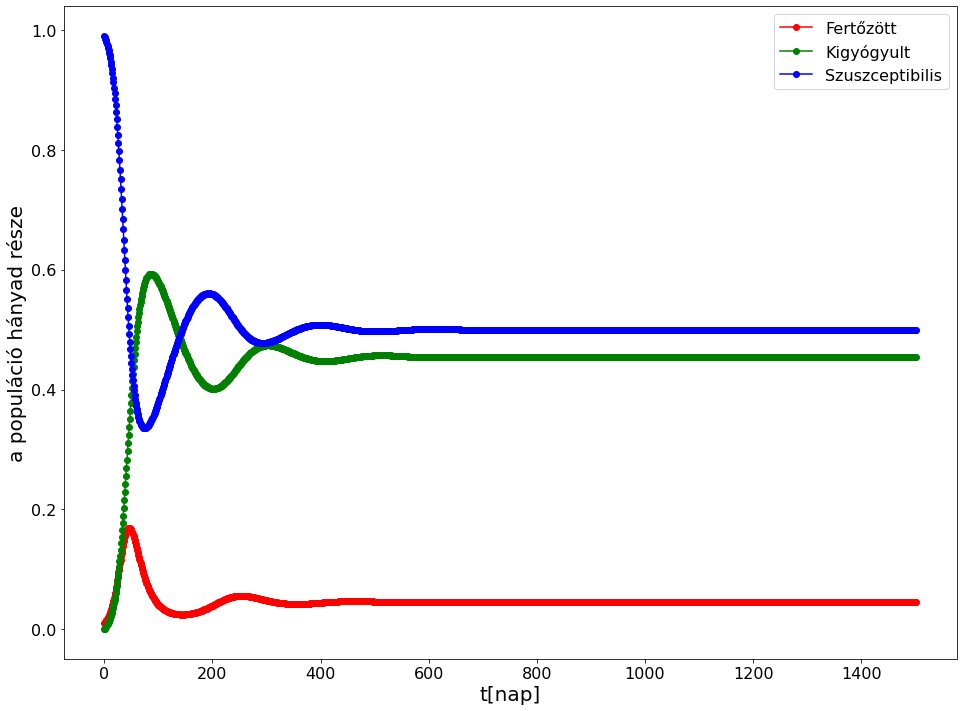

In [12]:
i, r = rk(0.01, 0, 1500)
abra(i,r)

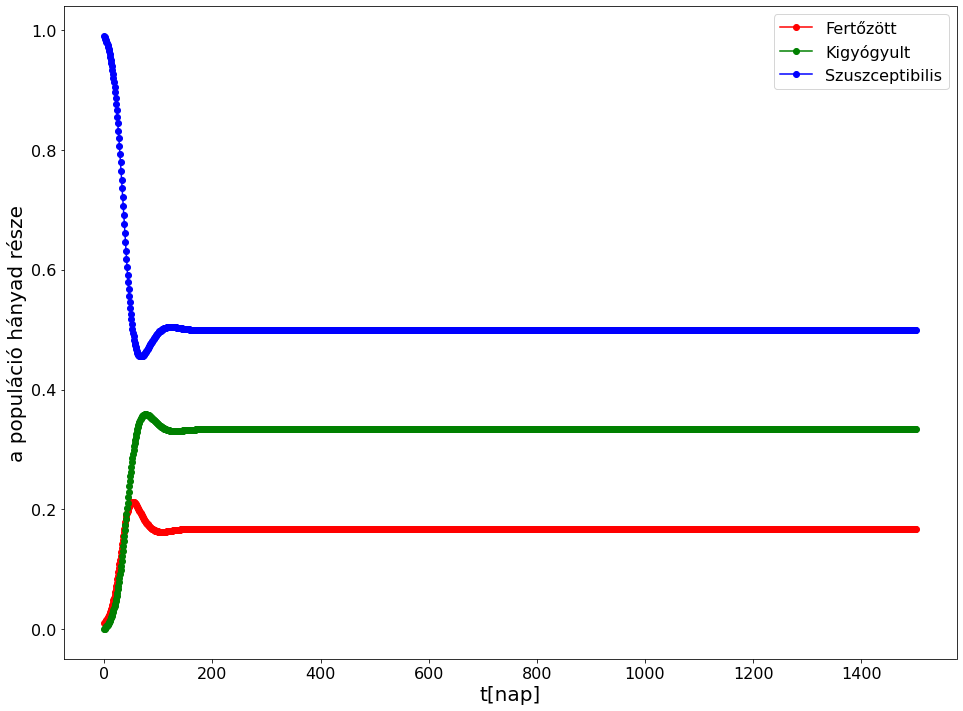

In [13]:
mu = 0.05
i, r = rk(0.01, 0, 1500)
abra(i,r)

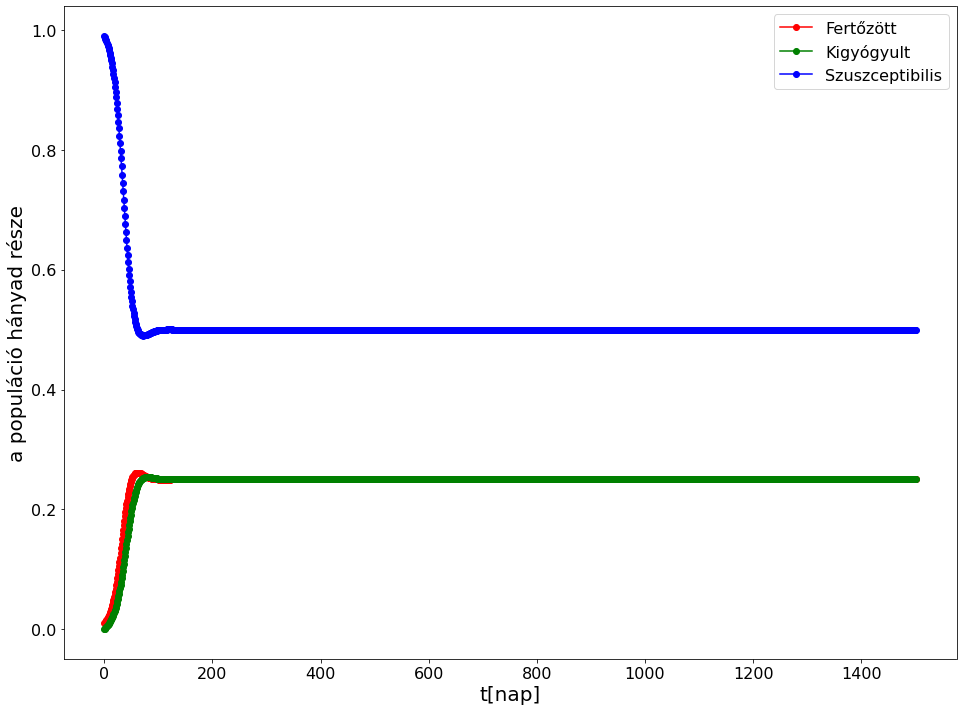

In [14]:
mu = 0.1
i, r = rk(0.01, 0, 1500)
abra(i,r)

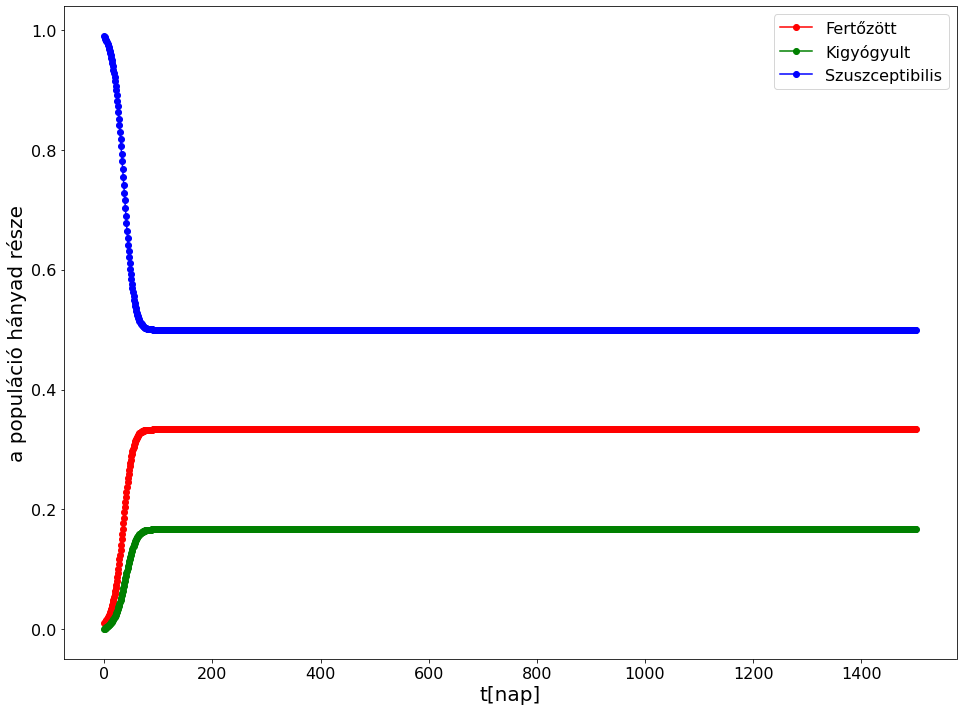

In [15]:
mu = 0.2
i, r = rk(0.01, 0, 1500)
abra(i,r)

A $\mu$ tulajdonképpen azt teszi, hogy a kigyógyultak bizonyos százaléka "spontán" átkerül a szuszceptibilisek halmazába. Ekkor beáll egy egyensúly, mely $\mu=0$ esetén nem - sejtés: pont annyian fognak bekerülni a szuszceptibilisek közé, amennyien megfertőződnek. Ez szépen látszik az összes ábrán : $s-r = i$. Ezt összeegyeztetve az $s+i+r=1$ összefüggéssel kijön, hogy $s=0.5$, mely állítást szintén alátámasztja az előző négy ábra. Így már kizárólag egy összefüggés marad $i$ és $r$ között, melyet egyértelműen megszab $\mu$ és $\gamma$.

### 3. feladat

Ehhez szükség lesz a módosított $R_0$-ra is.

Először számoljuk ki az egyensúlyi $s$, $i$ és $r$ értékeket!

$$ \frac{ds}{dt} = 0 \rightarrow \beta \cdot s \cdot i = \mu \cdot r $$

$$ \frac{di}{dt} = 0 \rightarrow \beta \cdot s \cdot i = \gamma \cdot i $$

$$ \frac{dr}{dt} = 0 \rightarrow \gamma \cdot i = \mu \cdot r $$

A második egyenletből :

$$ s = \frac{\gamma}{\beta} $$

Valamint :

$$ r = \frac{\gamma}{\mu}\cdot i $$

És tudjuk, hogy $ s + r + i = 1$, tehát

$$ i = \frac{ 1 - \frac{\gamma}{\beta} }{ 1 + \frac{\gamma}{\mu} } $$

és

$$ r = \frac{ 1 - \frac{\gamma}{\beta} }{ 1 + \frac{\mu}{\gamma} } $$

Ezeknek megfelelően az alábbi függvény kiírja az egyensúlyi értékeket.

In [16]:
def steady(i,r):
    sst = gamma/beta
    ist = (1-sst)/(1+ (gamma/mu) )
    rst = (1-sst)/(1+ (mu/gamma) )
    
    print("||s egyensúlyi érték||")
    print("Analitikus : " + str(sst))
    print("Numerikus : " + str((1-i-r)[-1]))
    print("\n")
    print("||i egyensúlyi érték||")
    print("Analitikus : " + str(ist))
    print("Numerikus : " + str(i[-1]))
    print("\n")
    print("||r egyensúlyi érték||")
    print("Analitikus : " + str(rst))
    print("Numerikus : " + str(r[-1]))

# Módosított $R_0$

Ez alatt azt értjük, hogy

$$ R_0 = \frac{\beta}{\gamma + \mu}$$

||s egyensúlyi érték||
Analitikus : 0.4545454545454546
Numerikus : 0.4545455111379972


||i egyensúlyi érték||
Analitikus : 0.04958677685950413
Numerikus : 0.049586763568680886


||r egyensúlyi érték||
Analitikus : 0.4958677685950412
Numerikus : 0.49586772529332196


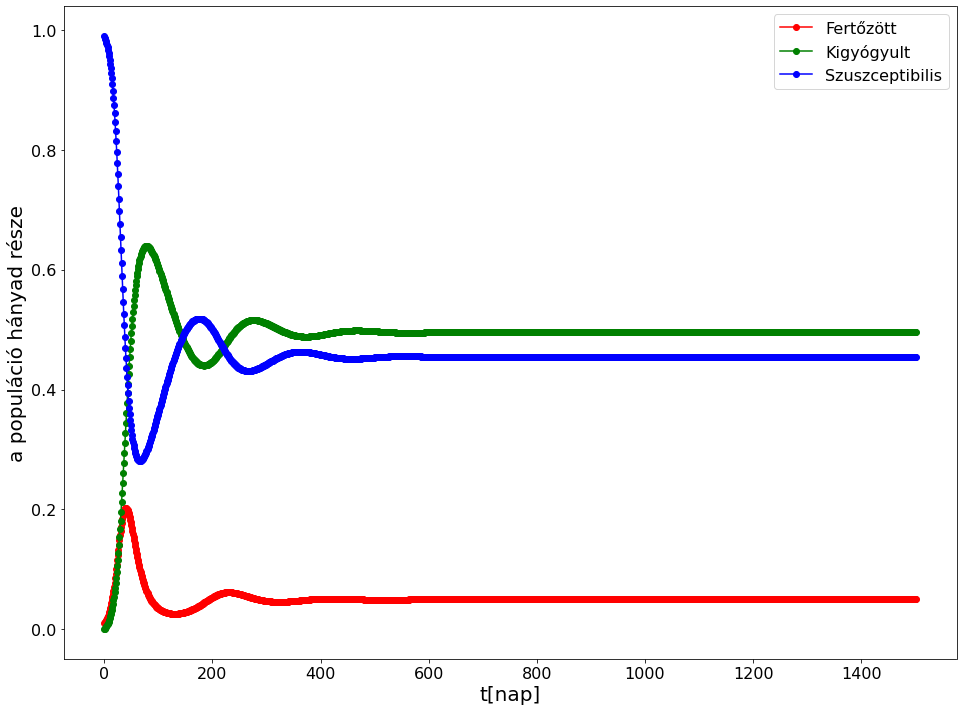

In [17]:
mu = 0.01
beta = R0*(mu + gamma)
i, r = rk(0.01, 0, 1500)
steady(i,r)
abra(i,r)

||s egyensúlyi érték||
Analitikus : 0.3333333333333333
Numerikus : 0.3333333333333332


||i egyensúlyi érték||
Analitikus : 0.22222222222222224
Numerikus : 0.22222222222222207


||r egyensúlyi érték||
Analitikus : 0.4444444444444445
Numerikus : 0.4444444444444447


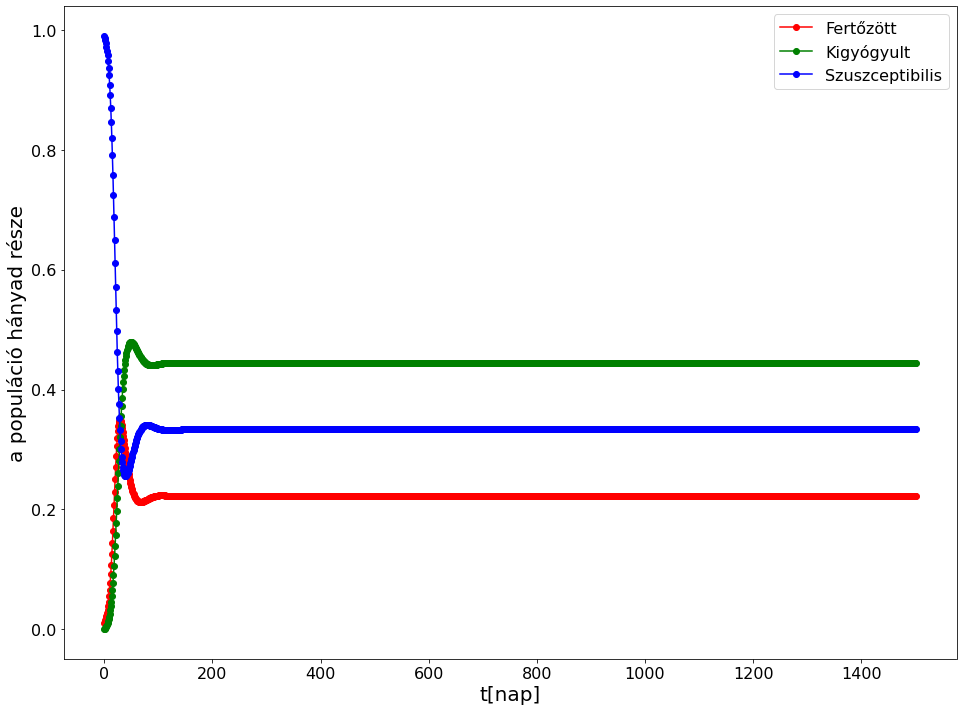

In [18]:
mu = 0.05
beta = R0*(mu + gamma)
i, r = rk(0.01, 0, 1500)
steady(i,r)
abra(i,r)

||s egyensúlyi érték||
Analitikus : 0.25
Numerikus : 0.2499999999999999


||i egyensúlyi érték||
Analitikus : 0.375
Numerikus : 0.3750000000000001


||r egyensúlyi érték||
Analitikus : 0.375
Numerikus : 0.375


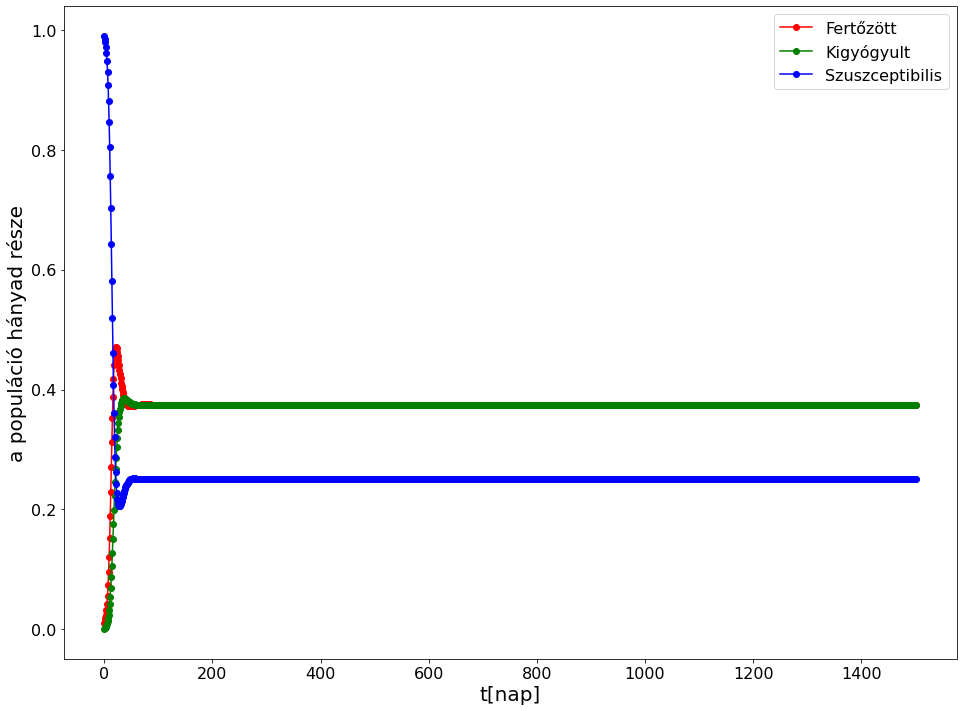

In [19]:
mu = 0.1
beta = R0*(mu + gamma)
i, r = rk(0.01, 0, 1500)
steady(i,r)
abra(i,r)

||s egyensúlyi érték||
Analitikus : 0.16666666666666666
Numerikus : 0.16666666666666652


||i egyensúlyi érték||
Analitikus : 0.5555555555555556
Numerikus : 0.5555555555555556


||r egyensúlyi érték||
Analitikus : 0.2777777777777778
Numerikus : 0.2777777777777779


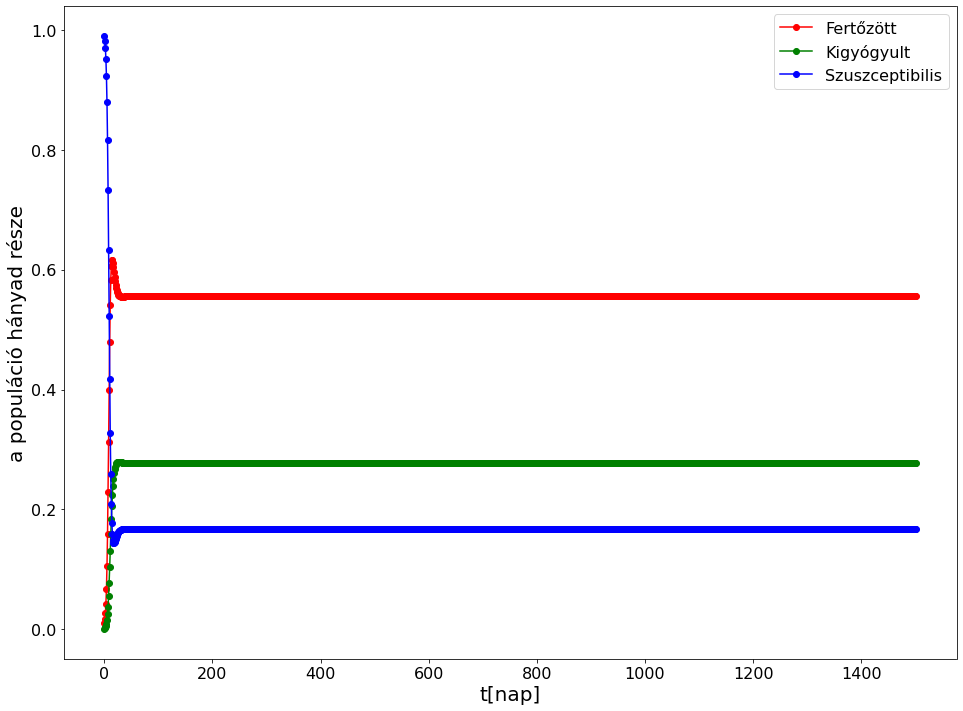

In [20]:
mu = 0.2
beta = R0*(mu + gamma)
i, r = rk(0.01, 0, 1500)
steady(i,r)
abra(i,r)

||s egyensúlyi érték||
Analitikus : 0.08333333333333334
Numerikus : 0.08333333333333337


||i egyensúlyi érték||
Analitikus : 0.7638888888888888
Numerikus : 0.7638888888888888


||r egyensúlyi érték||
Analitikus : 0.15277777777777776
Numerikus : 0.1527777777777778


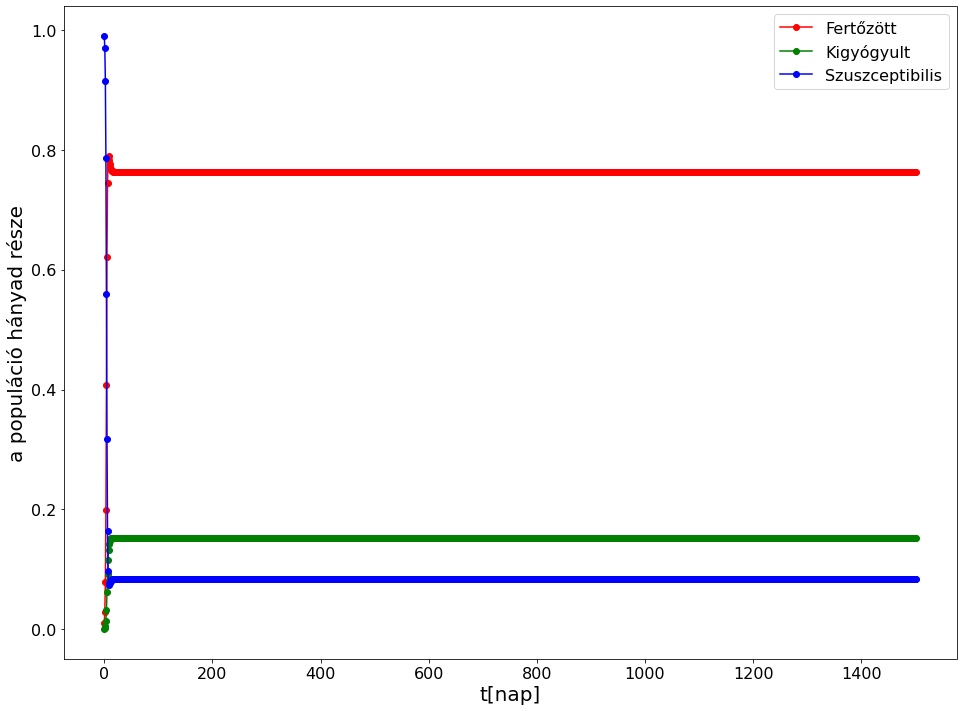

In [21]:
mu = 0.5
beta = R0*(mu + gamma)
i, r = rk(0.01, 0, 1500)
steady(i,r)
abra(i,r)

Ez mégis valóságosabb eredménynek tűnik, mivel más immunitási faktornál más stabil $s$ állapot jött létre.

Ha sorra nézzük az ábrákat, azt vehetjük észre, hogy egyre nagyobb eséllyel lesznek újra szuszceptibilisek az alanyok, de gyorsan ki is gyógyulnak, végül már több fertőzött van, mint szuszceptibilis és kigyógyult együttvéve(!).

Amint az ábra feletti sorok mutatják, $1500$ nap szimuláció bőven elég ahhoz, hogy $s$, $i$ és $r$ konvergáljanak névleges értékükhöz. (Meghökkentően sok tizedes egyezés van)

Az egyensúlyi helyzet körüli oszcillációk csillapított rezgések, $f(t) = e^{-\lambda\cdot t} \cdot \sin(\omega \cdot t + \phi_0)$. A deriváltakból látszik, hogy a negatív tagok felelősek a $\lambda$-áért, a pozitívak pedig $\omega$-áért. Az $i$-nél ez pont jól látszódik, de egyéb esetben a megfelelő változókat variálva fellelhető az összefüggés - vigyázva arra, hogy a rendszer csatolt, tehát egyiket változtatva a másik kettő is változik (erre a veszélyre is pont jó példa $i$, mivel $\beta\cdot s = \gamma$ az egyensúlyi állapotban, így $i'=0$-t kapnánk...).